In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

%matplotlib inline

In [ ]:
import torch
import torchvision as trv
import torchvision.datasets as ds
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms.functional as F

In [ ]:
def imshow(img):
    img = img / 2 + 0.5 # нормализация: [-1,1] --> [0,1]
    npimg = img.numpy()
    plt.figure(figsize = (30,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

#  Read db and apply data augmentation

In [ ]:
!git clone https://github.com/Sitnich/ssyp-2022-materials

!unzip ssyp-2022-materials/data/pokemon.zip -d pokemon/

Cloning into 'ssyp-2022-materials'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 34 (delta 4), reused 2 (delta 0), pack-reused 21
Unpacking objects: 100% (34/34), done.
Archive:  ssyp-2022-materials/data/pokemon.zip
  inflating: pokemon/official-jpg-named/abomasnow.jpg  
  inflating: pokemon/official-jpg-named/abra.jpg  
  inflating: pokemon/official-jpg-named/absol.jpg  
  inflating: pokemon/official-jpg-named/accelgor.jpg  
  inflating: pokemon/official-jpg-named/aegislash-shield.jpg  
  inflating: pokemon/official-jpg-named/aerodactyl.jpg  
  inflating: pokemon/official-jpg-named/aggron.jpg  
  inflating: pokemon/official-jpg-named/aipom.jpg  
  inflating: pokemon/official-jpg-named/alakazam.jpg  
  inflating: pokemon/official-jpg-named/alcremie.jpg  
  inflating: pokemon/official-jpg-named/alomomola.jpg  
  inflating: pokemon/official-jpg-named/altaria.jpg  
  inflating: pokemon

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

pokemon_path = "pokemon/"

Mounted at /content/gdrive


In [ ]:
dataset = ds.ImageFolder(root=pokemon_path,
       transform=transforms.Compose([
       transforms.Resize(size=[64,64]),
       transforms.RandomHorizontalFlip(),
       transforms.RandomRotation(degrees=[0.2, 0.8]),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                         shuffle=True, num_workers=int(2))

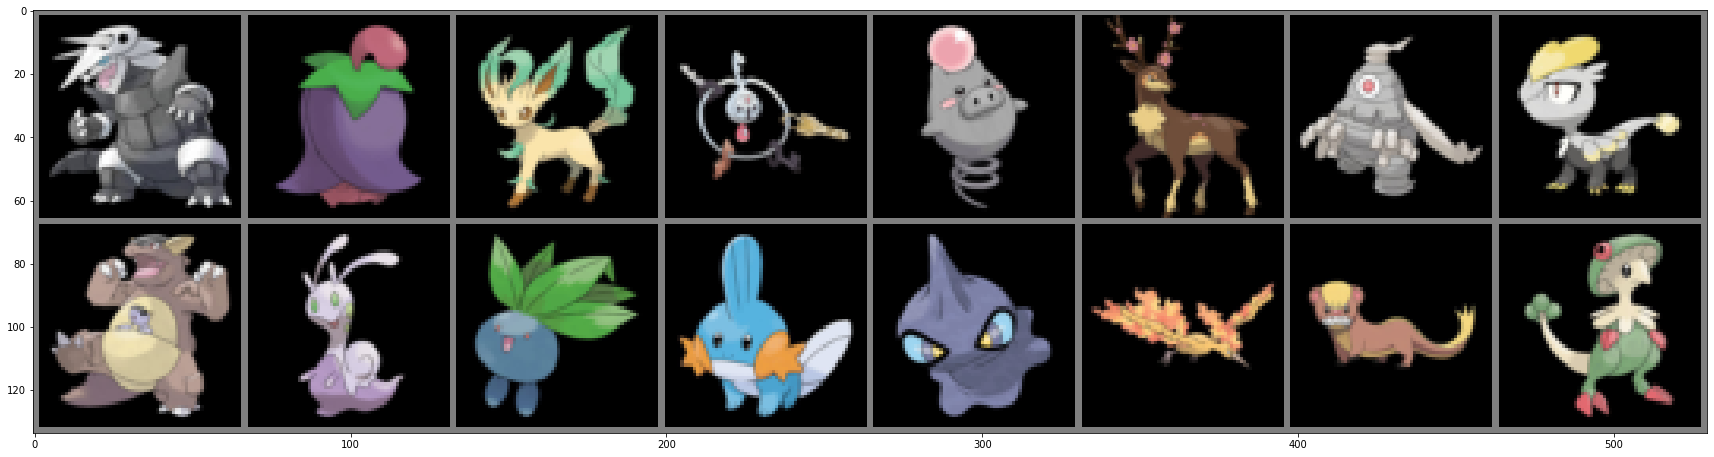

In [ ]:
# вытащим батч изображений из даталоадера
dataiter = iter(dataloader)
images, labels = dataiter.next()
imshow(trv.utils.make_grid(images))

# Строим DCGAN

In [ ]:
n_channels = 3
ndf = 128
ngf = 128
latent_dim = 100 # скрытая размерность
batch_size = 16

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Генератор

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            ##nn.ConvTranspose2d(latent_dim, ngf * 16, 4, 1, 0, bias=False),
            ##nn.BatchNorm2d(ngf * 16),
            ##nn.ReLU(True),
            ## ngf * 8 x 4 x 4

            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # ngf * 8 x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # ngf * 4 x 8 x 8

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # ngf * 2 x 16 x 16

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # ngf x 32 x 32

            nn.ConvTranspose2d(ngf, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # n_channels x 64 x 64
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
G = Generator()
print(G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            # n_channels x 64 x 64
            nn.Conv2d(n_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # ndf x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # ndf*2 x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # ndf*4 x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            ## ndf*8 x 8 x 8
            ## nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            ## nn.BatchNorm2d(ndf * 16),
            ## nn.LeakyReLU(0.2, inplace=True),

            # ndf * 8 x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()

        )
    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)
    
    

In [ ]:
D = Discriminator()
print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Setup

In [ ]:
criterion = nn.BCELoss()

In [ ]:
input = torch.FloatTensor(batch_size, 3, 128, 128)
noise = torch.FloatTensor(batch_size, latent_dim, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)

label = torch.FloatTensor(batch_size)

In [ ]:
# Использование GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
    D.cuda()
    G.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise = noise.cuda()

In [ ]:
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
n_epochs = 200
output_path = "/content/gdrive/MyDrive/test-output/"

In [ ]:
D.load_state_dict(torch.load('/content/gdrive/MyDrive/DCGAN_best_D.model'))
G.load_state_dict(torch.load('/content/gdrive/MyDrive/DCGAN_best_G.model'))

for epoch in range(500, 600):
    total_batches = 0
    gen_loss_avg = 0
    disc_loss_avg = 0
    for i, data in tqdm(enumerate(dataloader, 0), total=(len(dataset) + batch_size) // batch_size):
        real, _ = data
        if len(real) < batch_size:
            continue
        total_batches += 1

        ## Positive update
        D.zero_grad()
        bs = real.size(0)
        if use_cuda and torch.cuda.is_available():
            real = real.cuda()
        input.resize_as_(real).copy_(real)
        label.resize_(bs).fill_(1)
      
        output = D(input)
        loss_r = criterion(output, label)
        loss_r.backward()
      
        ## Negative update
        noise.resize_(bs, latent_dim, 1, 1).normal_(0, 1)
        fake = G(noise)
        label = label.fill_(0)
        output = D(fake.detach())
        loss_f = criterion(output, label)
        loss_f.backward()
      
        loss_d = loss_r + loss_f
        optimizerD.step()
        disc_loss_avg += loss_d.item()
      
        # Generator update
        G.zero_grad()
        label = label.fill_(1)
        output = D(fake)
        loss_g = criterion(output, label)
        loss_g.backward()
        optimizerG.step()
        gen_loss_avg += loss_g.item()


        if i % 50 == 0:
            noise.resize_(16, latent_dim, 1, 1).normal_(0, 1)
            fake = G(noise)
            vutils.save_image(fake.data, output_path+ f'fake_samples_epoch_{epoch:03d}.png', normalize=True)
            torch.save(D.state_dict(), '/content/gdrive/MyDrive/DCGAN_best_D.model')
            torch.save(G.state_dict(), '/content/gdrive/MyDrive/DCGAN_best_G.model')

    print(f"\nEpoch {epoch+1} | Discriminator loss: {disc_loss_avg / total_batches:.4f} | Generator loss: {gen_loss_avg / total_batches:.4f}")

100%|██████████| 57/57 [00:07<00:00,  7.77it/s]


Epoch 501 | Discriminator loss: 0.0570 | Generator loss: 13.7589



100%|██████████| 57/57 [00:07<00:00,  7.83it/s]


Epoch 502 | Discriminator loss: 0.1271 | Generator loss: 10.7871



100%|██████████| 57/57 [00:07<00:00,  7.69it/s]


Epoch 503 | Discriminator loss: 0.0712 | Generator loss: 10.5599



100%|██████████| 57/57 [00:07<00:00,  7.76it/s]


Epoch 504 | Discriminator loss: 0.0314 | Generator loss: 9.1873



100%|██████████| 57/57 [00:07<00:00,  7.76it/s]


Epoch 505 | Discriminator loss: 0.0450 | Generator loss: 11.3848



100%|██████████| 57/57 [00:07<00:00,  7.56it/s]


Epoch 506 | Discriminator loss: 0.0486 | Generator loss: 11.8215



100%|██████████| 57/57 [00:07<00:00,  7.86it/s]


Epoch 507 | Discriminator loss: 0.0550 | Generator loss: 12.7307



100%|██████████| 57/57 [00:07<00:00,  7.84it/s]


Epoch 508 | Discriminator loss: 0.1056 | Generator loss: 12.1124



100%|██████████| 57/57 [00:07<00:00,  7.89it/s]


Epoch 509 | Discriminator loss: 0.0762 | Generator loss: 12.1476



100%|██████████| 57/57 [00:07<00:00,  7.95it/s]


Epoch 510 | Discriminator loss: 0.0463 | Generator loss: 10.8005



100%|██████████| 57/57 [00:07<00:00,  7.89it/s]


Epoch 511 | Discriminator loss: 0.0372 | Generator loss: 11.1764



100%|██████████| 57/57 [00:07<00:00,  7.22it/s]


Epoch 512 | Discriminator loss: 0.0462 | Generator loss: 10.3798



100%|██████████| 57/57 [00:07<00:00,  7.86it/s]


Epoch 513 | Discriminator loss: 0.0290 | Generator loss: 12.5236



100%|██████████| 57/57 [00:07<00:00,  7.87it/s]


Epoch 514 | Discriminator loss: 0.0246 | Generator loss: 10.7858



100%|██████████| 57/57 [00:07<00:00,  7.73it/s]


Epoch 515 | Discriminator loss: 0.0119 | Generator loss: 9.1311



100%|██████████| 57/57 [00:07<00:00,  7.87it/s]


Epoch 516 | Discriminator loss: 0.0166 | Generator loss: 10.8082



100%|██████████| 57/57 [00:07<00:00,  7.86it/s]


Epoch 517 | Discriminator loss: 0.0163 | Generator loss: 13.0911



100%|██████████| 57/57 [00:07<00:00,  7.83it/s]


Epoch 518 | Discriminator loss: 0.1048 | Generator loss: 17.0038



100%|██████████| 57/57 [00:07<00:00,  7.63it/s]


Epoch 519 | Discriminator loss: 0.0765 | Generator loss: 12.9616



100%|██████████| 57/57 [00:07<00:00,  7.86it/s]


Epoch 520 | Discriminator loss: 0.0519 | Generator loss: 12.0967



100%|██████████| 57/57 [00:07<00:00,  7.87it/s]


Epoch 521 | Discriminator loss: 0.0510 | Generator loss: 11.7874



100%|██████████| 57/57 [00:07<00:00,  7.91it/s]


Epoch 522 | Discriminator loss: 0.0260 | Generator loss: 10.3503



100%|██████████| 57/57 [00:07<00:00,  7.90it/s]


Epoch 523 | Discriminator loss: 0.0129 | Generator loss: 8.8790



100%|██████████| 57/57 [00:07<00:00,  7.88it/s]


Epoch 524 | Discriminator loss: 0.0174 | Generator loss: 14.4773



100%|██████████| 57/57 [00:07<00:00,  7.43it/s]


Epoch 525 | Discriminator loss: 0.0195 | Generator loss: 11.8834



100%|██████████| 57/57 [00:07<00:00,  7.88it/s]


Epoch 526 | Discriminator loss: 0.0141 | Generator loss: 10.9805



100%|██████████| 57/57 [00:07<00:00,  7.84it/s]


Epoch 527 | Discriminator loss: 0.0117 | Generator loss: 11.5756



100%|██████████| 57/57 [00:07<00:00,  7.43it/s]


Epoch 528 | Discriminator loss: 0.0111 | Generator loss: 9.4837



100%|██████████| 57/57 [00:08<00:00,  7.03it/s]


Epoch 529 | Discriminator loss: 0.0090 | Generator loss: 10.3644



100%|██████████| 57/57 [00:07<00:00,  7.77it/s]


Epoch 530 | Discriminator loss: 0.0131 | Generator loss: 11.5527



100%|██████████| 57/57 [00:07<00:00,  7.89it/s]


Epoch 531 | Discriminator loss: 0.0122 | Generator loss: 10.9902



100%|██████████| 57/57 [00:07<00:00,  7.88it/s]


Epoch 532 | Discriminator loss: 0.0151 | Generator loss: 20.2219



100%|██████████| 57/57 [00:07<00:00,  7.80it/s]


Epoch 533 | Discriminator loss: 0.0344 | Generator loss: 15.8957



100%|██████████| 57/57 [00:07<00:00,  7.89it/s]


Epoch 534 | Discriminator loss: 0.1401 | Generator loss: 21.9345



100%|██████████| 57/57 [00:07<00:00,  7.91it/s]


Epoch 535 | Discriminator loss: 0.2192 | Generator loss: 20.2338



100%|██████████| 57/57 [00:07<00:00,  7.72it/s]


Epoch 536 | Discriminator loss: 0.0894 | Generator loss: 16.1511



100%|██████████| 57/57 [00:07<00:00,  7.90it/s]


Epoch 537 | Discriminator loss: 0.0800 | Generator loss: 14.4668



100%|██████████| 57/57 [00:07<00:00,  7.84it/s]


Epoch 538 | Discriminator loss: 0.0248 | Generator loss: 9.0158



100%|██████████| 57/57 [00:07<00:00,  7.90it/s]


Epoch 539 | Discriminator loss: 0.1004 | Generator loss: 16.9055



100%|██████████| 57/57 [00:07<00:00,  7.60it/s]


Epoch 540 | Discriminator loss: 0.0642 | Generator loss: 12.9538



100%|██████████| 57/57 [00:07<00:00,  7.88it/s]


Epoch 541 | Discriminator loss: 0.0408 | Generator loss: 10.3460



100%|██████████| 57/57 [00:07<00:00,  7.85it/s]


Epoch 542 | Discriminator loss: 0.0414 | Generator loss: 15.2468



100%|██████████| 57/57 [00:07<00:00,  7.63it/s]


Epoch 543 | Discriminator loss: 0.0260 | Generator loss: 9.5504



100%|██████████| 57/57 [00:07<00:00,  7.84it/s]


Epoch 544 | Discriminator loss: 0.0278 | Generator loss: 9.8871



100%|██████████| 57/57 [00:07<00:00,  7.83it/s]


Epoch 545 | Discriminator loss: 0.0186 | Generator loss: 8.6113



100%|██████████| 57/57 [00:08<00:00,  6.89it/s]


Epoch 546 | Discriminator loss: 0.0215 | Generator loss: 12.8871



100%|██████████| 57/57 [00:07<00:00,  7.87it/s]


Epoch 547 | Discriminator loss: 0.0133 | Generator loss: 8.9532



100%|██████████| 57/57 [00:07<00:00,  7.83it/s]


Epoch 548 | Discriminator loss: 0.0095 | Generator loss: 9.1828



100%|██████████| 57/57 [00:07<00:00,  7.94it/s]


Epoch 549 | Discriminator loss: 0.0158 | Generator loss: 10.9662



100%|██████████| 57/57 [00:07<00:00,  7.87it/s]


Epoch 550 | Discriminator loss: 0.0166 | Generator loss: 13.5534



100%|██████████| 57/57 [00:07<00:00,  7.87it/s]


Epoch 551 | Discriminator loss: 0.0238 | Generator loss: 11.3256



100%|██████████| 57/57 [00:07<00:00,  7.90it/s]


Epoch 552 | Discriminator loss: 0.0154 | Generator loss: 18.7597



100%|██████████| 57/57 [00:07<00:00,  7.91it/s]


Epoch 553 | Discriminator loss: 0.0112 | Generator loss: 9.4081



100%|██████████| 57/57 [00:07<00:00,  7.73it/s]


Epoch 554 | Discriminator loss: 0.0377 | Generator loss: 22.6215



100%|██████████| 57/57 [00:07<00:00,  7.90it/s]


Epoch 555 | Discriminator loss: 0.0387 | Generator loss: 17.8800



100%|██████████| 57/57 [00:07<00:00,  7.90it/s]


Epoch 556 | Discriminator loss: 0.1168 | Generator loss: 17.2150



100%|██████████| 57/57 [00:07<00:00,  7.88it/s]


Epoch 557 | Discriminator loss: 0.0959 | Generator loss: 19.6451



100%|██████████| 57/57 [00:07<00:00,  7.63it/s]


Epoch 558 | Discriminator loss: 0.0801 | Generator loss: 12.8708



100%|██████████| 57/57 [00:07<00:00,  7.89it/s]


Epoch 559 | Discriminator loss: 0.0478 | Generator loss: 12.2508



100%|██████████| 57/57 [00:07<00:00,  7.78it/s]


Epoch 560 | Discriminator loss: 0.0398 | Generator loss: 13.9188



100%|██████████| 57/57 [00:07<00:00,  7.90it/s]


Epoch 561 | Discriminator loss: 0.0905 | Generator loss: 17.4667



100%|██████████| 57/57 [00:07<00:00,  7.82it/s]


Epoch 562 | Discriminator loss: 0.0531 | Generator loss: 15.8761



100%|██████████| 57/57 [00:07<00:00,  7.15it/s]


Epoch 563 | Discriminator loss: 0.0226 | Generator loss: 10.1032



100%|██████████| 57/57 [00:07<00:00,  7.59it/s]


Epoch 564 | Discriminator loss: 0.0300 | Generator loss: 10.8874



100%|██████████| 57/57 [00:07<00:00,  7.83it/s]


Epoch 565 | Discriminator loss: 0.0224 | Generator loss: 13.3676



100%|██████████| 57/57 [00:07<00:00,  7.88it/s]


Epoch 566 | Discriminator loss: 0.0347 | Generator loss: 10.6168



100%|██████████| 57/57 [00:07<00:00,  7.79it/s]


Epoch 567 | Discriminator loss: 0.0184 | Generator loss: 10.2835



100%|██████████| 57/57 [00:07<00:00,  7.89it/s]


Epoch 568 | Discriminator loss: 0.0177 | Generator loss: 10.8090



100%|██████████| 57/57 [00:07<00:00,  7.85it/s]


Epoch 569 | Discriminator loss: 0.0308 | Generator loss: 13.2956



100%|██████████| 57/57 [00:07<00:00,  7.41it/s]


Epoch 570 | Discriminator loss: 0.0301 | Generator loss: 14.2960



100%|██████████| 57/57 [00:07<00:00,  7.88it/s]


Epoch 571 | Discriminator loss: 0.0087 | Generator loss: 9.2822



100%|██████████| 57/57 [00:07<00:00,  7.85it/s]


Epoch 572 | Discriminator loss: 0.0173 | Generator loss: 14.4418



100%|██████████| 57/57 [00:07<00:00,  7.44it/s]


Epoch 573 | Discriminator loss: 0.0098 | Generator loss: 10.9811



100%|██████████| 57/57 [00:07<00:00,  7.90it/s]


Epoch 574 | Discriminator loss: 0.0206 | Generator loss: 12.5635



100%|██████████| 57/57 [00:07<00:00,  7.86it/s]


Epoch 575 | Discriminator loss: 0.0200 | Generator loss: 18.1462



100%|██████████| 57/57 [00:07<00:00,  7.86it/s]


Epoch 576 | Discriminator loss: 0.0299 | Generator loss: 32.8565



100%|██████████| 57/57 [00:07<00:00,  7.85it/s]


Epoch 577 | Discriminator loss: 0.0345 | Generator loss: 30.6520



100%|██████████| 57/57 [00:07<00:00,  7.81it/s]


Epoch 578 | Discriminator loss: 0.1718 | Generator loss: 28.0891



100%|██████████| 57/57 [00:07<00:00,  7.50it/s]


Epoch 579 | Discriminator loss: 0.0650 | Generator loss: 47.3468



100%|██████████| 57/57 [00:07<00:00,  7.24it/s]


Epoch 580 | Discriminator loss: 0.2860 | Generator loss: 22.4394



100%|██████████| 57/57 [00:07<00:00,  7.62it/s]


Epoch 581 | Discriminator loss: 0.1249 | Generator loss: 18.6070



100%|██████████| 57/57 [00:07<00:00,  7.85it/s]


Epoch 582 | Discriminator loss: 0.0917 | Generator loss: 17.7745



100%|██████████| 57/57 [00:07<00:00,  7.85it/s]


Epoch 583 | Discriminator loss: 0.0452 | Generator loss: 11.3885



100%|██████████| 57/57 [00:07<00:00,  7.77it/s]


Epoch 584 | Discriminator loss: 0.0866 | Generator loss: 15.0527



100%|██████████| 57/57 [00:07<00:00,  7.83it/s]


Epoch 585 | Discriminator loss: 0.0394 | Generator loss: 9.9758



100%|██████████| 57/57 [00:07<00:00,  7.86it/s]


Epoch 586 | Discriminator loss: 0.0319 | Generator loss: 10.8726



100%|██████████| 57/57 [00:07<00:00,  7.88it/s]


Epoch 587 | Discriminator loss: 0.0227 | Generator loss: 9.1614



100%|██████████| 57/57 [00:07<00:00,  7.92it/s]


Epoch 588 | Discriminator loss: 0.0192 | Generator loss: 8.7538



100%|██████████| 57/57 [00:07<00:00,  7.85it/s]


Epoch 589 | Discriminator loss: 0.0246 | Generator loss: 10.5026



100%|██████████| 57/57 [00:07<00:00,  7.87it/s]


Epoch 590 | Discriminator loss: 0.0284 | Generator loss: 10.4943



100%|██████████| 57/57 [00:07<00:00,  7.87it/s]


Epoch 591 | Discriminator loss: 0.0178 | Generator loss: 14.7474



100%|██████████| 57/57 [00:07<00:00,  7.88it/s]


Epoch 592 | Discriminator loss: 0.0130 | Generator loss: 8.8206



100%|██████████| 57/57 [00:07<00:00,  7.85it/s]


Epoch 593 | Discriminator loss: 0.0111 | Generator loss: 8.8753



100%|██████████| 57/57 [00:07<00:00,  7.86it/s]


Epoch 594 | Discriminator loss: 0.0328 | Generator loss: 15.9741



100%|██████████| 57/57 [00:07<00:00,  7.86it/s]


Epoch 595 | Discriminator loss: 0.0160 | Generator loss: 13.4601



100%|██████████| 57/57 [00:07<00:00,  7.73it/s]


Epoch 596 | Discriminator loss: 0.0209 | Generator loss: 11.6453



100%|██████████| 57/57 [00:08<00:00,  7.11it/s]


Epoch 597 | Discriminator loss: 0.0112 | Generator loss: 12.4527



100%|██████████| 57/57 [00:07<00:00,  7.90it/s]


Epoch 598 | Discriminator loss: 0.4386 | Generator loss: 24.3853



100%|██████████| 57/57 [00:07<00:00,  7.88it/s]


Epoch 599 | Discriminator loss: 0.0771 | Generator loss: 15.5272



100%|██████████| 57/57 [00:07<00:00,  7.90it/s]


Epoch 600 | Discriminator loss: 0.0536 | Generator loss: 12.4576
